In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
sns.set_theme()

## Load data

In [5]:
data = pd.read_csv('data/starships_clean.csv', index_col='id')

In [10]:
# Cast again date
data['stream_date'] = pd.to_datetime(data['stream_date'])

In [34]:
# Rename column
data.rename(columns={'level2': 'ship_type'}, inplace=True)
data.rename(columns={'stream_date': 'date'}, inplace=True)

## Explore

In [39]:
data

,ship_type,date,lon,lat
id,,,,
1,TIE Fighter,2007-05-18 12:00:00,-19.950145,27.552059
2,TIE bomber,2007-05-18 12:00:00,-19.925915,27.527897
3,TIE bomber,2007-05-18 12:00:00,-19.927374,27.527464
4,TIE Fighter,2007-05-18 12:00:00,-19.915460,27.516342
5,TIE Fighter,2007-05-18 12:00:00,-19.948334,27.557954
...,...,...,...,...
3459,Imperial SpaceShuttle,2020-03-21 12:00:00,-19.916284,27.515434
2524742,Imperial SpaceShuttle,2020-03-21 12:00:00,-19.949415,27.550263
2524752,Imperial SpaceShuttle,2020-03-21 12:00:00,-19.948473,27.550805


### Inspect id

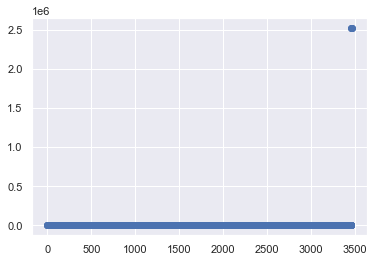

In [26]:
# Is id continuous?
plt.scatter(range(len(data.index)), data.index)

- There seems to have an outlier in the end of the series
- Id seems continuous (without the outlier)

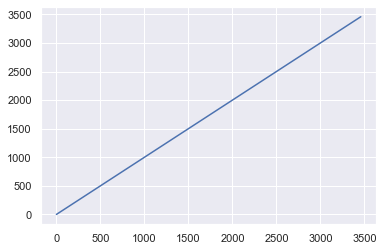

In [22]:
# (temprorarilly) Remove the outliers to zoom on the remaining ids
plt.plot(range(len(data.index[:-4])), data.index[:-4])

Analysis:
- Ids indeed seem continuous

Questions:
- Is there a meaning in the id?
- Is the id correlated with:
    - the type of starship?
    - the time (linear)
    - the year period (cyclical)

In [ ]:
# TODO: investigate

### Inspect stream_date

Text(0.5, 1.0, 'Complete date')

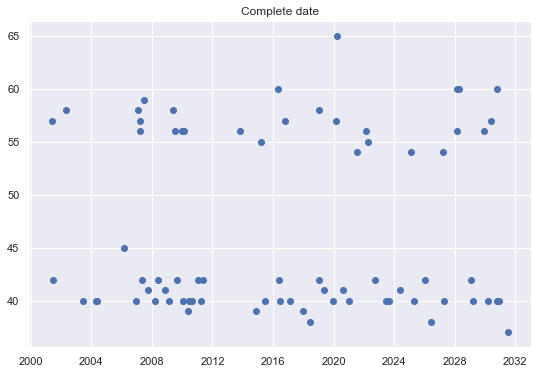

In [14]:
plt.figure(figsize=(9, 6))
date_counts = data['date'].value_counts()
plt.scatter(date_counts.index, date_counts.values)
plt.title('Complete date')

Conclusions:
- There are 2 types of snapshots:
    - 1 with 40 data points on avg
    - 1 with 57 data points on avg
- There is no trend (stationary)
- The variance is relatively low and constant / independent (heteroscedaticity)

Questions:
- Do some starships appear in one of the two snapshot more frequently / only?
- Why are there two snapshots, rather than a unique measure with an equal number
of data points each time?
- Is the type of snapshot correlated with the period during the year?


#### Test hyp: many data points during estival period, fewer during winter (because ships are hidden in their boxes)

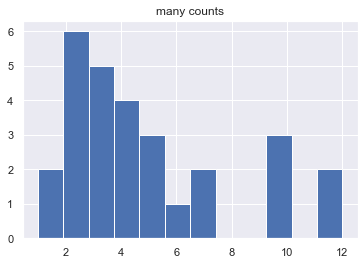

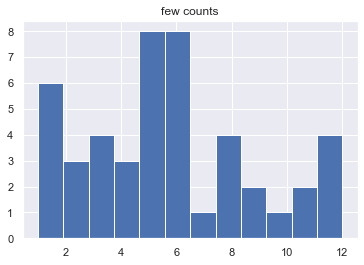

In [78]:
COUNT_LIMIT = 50

counts_by_date = data.groupby('date').count()
ma_many_ships = counts_by_date['ship_type'] > COUNT_LIMIT
months_many = counts_by_date[ma_many_ships].index.month
plt.hist(months_many, bins=12)
plt.title('many counts')
plt.show()

ma_few_ships = counts_by_date['ship_type'] < COUNT_LIMIT
months_few = counts_by_date[ma_few_ships].index.month
plt.hist(months_few, bins=12)
plt.title('few counts')
plt.show()

- There is no clear pattern. It is not correlated with specific months as expected

#### Test hyp: many data points during the week, fewer during week-end (because ships are hidden in their boxes)

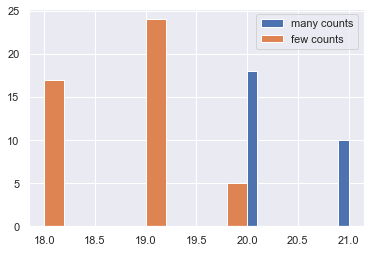

In [87]:
COUNT_LIMIT = 50

day_many = counts_by_date[ma_many_ships].index.day
plt.hist(day_many)

day_few = counts_by_date[ma_few_ships].index.day
plt.hist(day_few)

plt.legend(['many counts', 'few counts'])

In [84]:
print(day_many)
print(day_few)

- It is highly dependent of the day in week!
- but why?? (18 and 19 cannot be the week-end everytime)
- Maybe 18 and 19 are days for recovery, even though it might not be during the week-end (and its on another planet, maybe that's why!)

### Investigate ship_type

#### Ship_type repartition

In [37]:
# Total period
data['ship_type'].value_counts()

TIE Fighter              2034
Imperial SpaceShuttle     827
TIE bomber                511
Civilian Star Shuttle      89
Surveillance droid          2
Name: ship_type, dtype: int64

In [47]:
# Get extreme dates
date_first = data['date'].min()
date_last = data['date'].max()

# Masks
ma_snap_first = data['date'] == date_first
ma_snap_last = data['date'] == date_last

# Extract ship_type for the given dates
ship_type_first = data[ma_snap_first]['ship_type'].value_counts()
ship_type_last = data[ma_snap_last]['ship_type'].value_counts()

In [48]:
ship_type_first

TIE Fighter              38
Imperial SpaceShuttle    11
TIE bomber                7
Civilian Star Shuttle     1
Name: ship_type, dtype: int64

In [49]:
ship_type_last

TIE Fighter              21
Imperial SpaceShuttle    11
TIE bomber                5
Name: ship_type, dtype: int64

#### Evolution of each ship_type

In [55]:
# Get the count of a ship_type for each date
ma_type_tie_fighter = data['ship_type'] == 'TIE Fighter'
evol_count_tie_fighter = data[ma_type_tie_fighter].groupby('date').count()['ship_type']

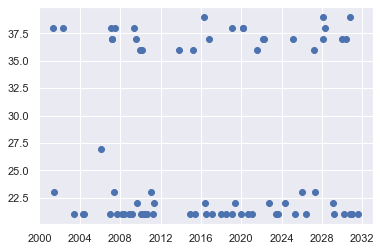

In [62]:
plt.scatter(evol_count_tie_fighter.index, evol_count_tie_fighter)

- Inevitably the same pattern in the count of data points appears

In [63]:
data[ma_type_tie_fighter]

,ship_type,date,lon,lat
id,,,,
1,TIE Fighter,2007-05-18 12:00:00,-19.950145,27.552059
4,TIE Fighter,2007-05-18 12:00:00,-19.915460,27.516342
5,TIE Fighter,2007-05-18 12:00:00,-19.948334,27.557954
7,TIE Fighter,2007-05-18 12:00:00,-19.950314,27.552943
8,TIE Fighter,2007-05-18 12:00:00,-19.951056,27.552835
...,...,...,...,...
3435,TIE Fighter,2028-04-21 12:00:00,-19.948957,27.551058
3438,TIE Fighter,2028-04-21 12:00:00,-19.947813,27.548688
3442,TIE Fighter,2028-04-21 12:00:00,-19.939484,27.540039
